In [1]:
# ------------ Importing Required Libraries -------------
import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from PIL import Image
import cv2
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt


2025-07-03 13:22:12.012275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751548932.304372      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751548932.386069      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# ---------------- Reproducibility ----------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# ---------------- Paths ----------------
DATA_DIR = '/kaggle/input/facecom/Comys_Hackathon5/Task_A'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
MODEL_SAVE_PATH = './saved_model'

os.makedirs(MODEL_SAVE_PATH, exist_ok=True)


In [4]:
# ---------------- Dataset ----------------
class FaceDataset(Dataset):
    def __init__(self, root_dir, processor, transform=None):
        self.processor = processor
        self.transform = transform
        self.data = []

        for label, class_name in enumerate(['male', 'female']):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.data.append((os.path.join(class_dir, img_name), label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        
        # Read with OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply strong denoising
        image = cv2.fastNlMeansDenoisingColored(image, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)
        
        # Convert to PIL for transforms
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].squeeze(0)
        return pixel_values, torch.tensor(label)

# ---------------- Model with Custom Classifier ----------------
class GenderClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

        dummy_image = torch.randn(1, 3, 224, 224)
        with torch.no_grad():
            image_features = self.clip.get_image_features(pixel_values=dummy_image)
        feature_dim = image_features.shape[1]

        self.classifier = torch.nn.Linear(feature_dim, 2)

    def forward(self, pixel_values):
        image_features = self.clip.get_image_features(pixel_values=pixel_values)
        logits = self.classifier(image_features)
        return logits

# ---------------- Setup ----------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = GenderClassifier().to(device)

train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(15),
])

val_transform = T.Compose([
    T.Resize((224, 224)),
])

train_dataset = FaceDataset(TRAIN_DIR, processor, train_transform)
val_dataset = FaceDataset(VAL_DIR, processor, val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

train_labels = [label for _, label in train_dataset.data]
class_counts = Counter(train_labels)
total = sum(class_counts.values())
class_weights = torch.tensor([
    total / class_counts[0],
    total / class_counts[1],
], dtype=torch.float).to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [5]:
# ---------------- Training with Early Stopping ----------------
EPOCHS = 30
patience = 5
best_f1 = 0
early_stop_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0

    for pixel_values, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        pixel_values, labels = pixel_values.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(pixel_values)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f}")

    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for pixel_values, labels in val_loader:
            pixel_values, labels = pixel_values.to(device), labels.to(device)
            logits = model(pixel_values)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Validation - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        early_stop_counter = 0
        torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, "model_weights.pt"))
        print("Best model weights saved.")
    else:
        early_stop_counter += 1
        print(f"Early stopping patience counter: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break



Epoch 1/30: 100%|██████████| 121/121 [29:17<00:00, 14.52s/it]


Epoch 1 Loss: 0.2920
Validation - Accuracy: 0.8673, Precision: 0.5878, Recall: 0.9747, F1-Score: 0.7333
Best model weights saved.


Epoch 2/30: 100%|██████████| 121/121 [28:45<00:00, 14.26s/it]


Epoch 2 Loss: 0.1955
Validation - Accuracy: 0.9028, Precision: 0.7879, Recall: 0.6582, F1-Score: 0.7172
Early stopping patience counter: 1/5


Epoch 3/30: 100%|██████████| 121/121 [28:29<00:00, 14.13s/it]


Epoch 3 Loss: 0.1796
Validation - Accuracy: 0.9028, Precision: 0.8654, Recall: 0.5696, F1-Score: 0.6870
Early stopping patience counter: 2/5


Epoch 4/30: 100%|██████████| 121/121 [28:43<00:00, 14.24s/it]


Epoch 4 Loss: 0.2073
Validation - Accuracy: 0.9028, Precision: 0.7209, Recall: 0.7848, F1-Score: 0.7515
Best model weights saved.


Epoch 5/30: 100%|██████████| 121/121 [28:44<00:00, 14.25s/it]


Epoch 5 Loss: 0.1445
Validation - Accuracy: 0.8555, Precision: 0.5692, Recall: 0.9367, F1-Score: 0.7081
Early stopping patience counter: 1/5


Epoch 6/30: 100%|██████████| 121/121 [28:44<00:00, 14.25s/it]


Epoch 6 Loss: 0.1442
Validation - Accuracy: 0.8815, Precision: 0.6306, Recall: 0.8861, F1-Score: 0.7368
Early stopping patience counter: 2/5


Epoch 7/30: 100%|██████████| 121/121 [28:41<00:00, 14.23s/it]


Epoch 7 Loss: 0.1840
Validation - Accuracy: 0.8863, Precision: 0.6505, Recall: 0.8481, F1-Score: 0.7363
Early stopping patience counter: 3/5


Epoch 8/30: 100%|██████████| 121/121 [28:36<00:00, 14.18s/it]


Epoch 8 Loss: 0.1414
Validation - Accuracy: 0.8152, Precision: 0.5034, Recall: 0.9367, F1-Score: 0.6549
Early stopping patience counter: 4/5


Epoch 9/30: 100%|██████████| 121/121 [28:44<00:00, 14.25s/it]


Epoch 9 Loss: 0.1151
Validation - Accuracy: 0.9052, Precision: 0.7407, Recall: 0.7595, F1-Score: 0.7500
Early stopping patience counter: 5/5
Early stopping triggered.


In [6]:
# ---------------- Saving Final Model Weights & Processor ----------------
torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, "model_weights.pt"))
processor.save_pretrained(MODEL_SAVE_PATH)
print(f" Final model weights and processor saved to {MODEL_SAVE_PATH}")

 Final model weights and processor saved to ./saved_model


In [7]:
# ---------------- Final Evaluation on Validation Set ----------------
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "model_weights.pt")))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for pixel_values, labels in tqdm(val_loader, desc="Final Validation Evaluation"):
        pixel_values, labels = pixel_values.to(device), labels.to(device)
        logits = model(pixel_values)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\n Classification Report on Validation Set:")
print(classification_report(all_labels, all_preds, target_names=["Male", "Female"]))

Final Validation Evaluation: 100%|██████████| 27/27 [06:30<00:00, 14.48s/it]


 Classification Report on Validation Set:
              precision    recall  f1-score   support

        Male       0.94      0.94      0.94       343
      Female       0.74      0.76      0.75        79

    accuracy                           0.91       422
   macro avg       0.84      0.85      0.85       422
weighted avg       0.91      0.91      0.91       422



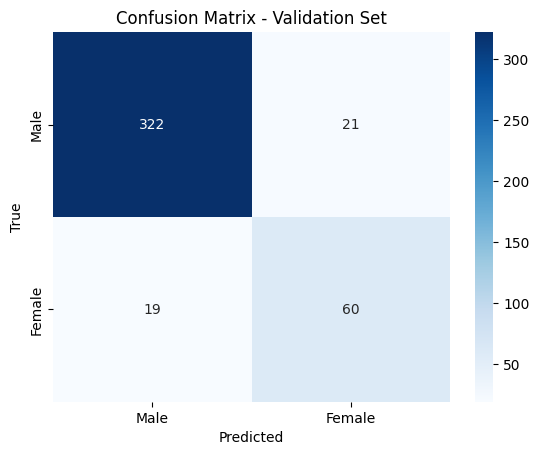

In [8]:
# ---------------- Confusion Matrix ----------------
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Male", "Female"], yticklabels=["Male", "Female"])
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()